<a href="https://colab.research.google.com/github/takakishi/HEC_DS_ML_project/blob/main/src/BERT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install bert-tensorflow
!pip install spacy-transformers
#!python -m spacy download fr_core_news_sm
!pip install tensorflow_text
!pip install -q tf-models-official

In [2]:
# Libraries
import pandas as pd
import numpy as np
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from gensim.models import Word2Vec
import spacy
#import spacy_transformers
import torch
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.models import KeyedVectors
from huggingface_hub import hf_hub_download
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [3]:
# Import Data
sample_submission = pd.read_csv('https://raw.githubusercontent.com/takakishi/HEC_DS_ML_project/main/data/data_raw/sample_submission.csv')
training_data = pd.read_csv('https://raw.githubusercontent.com/takakishi/HEC_DS_ML_project/main/data/data_raw/training_data.csv')
unlabelled_test_data = pd.read_csv('https://raw.githubusercontent.com/takakishi/HEC_DS_ML_project/main/data/data_raw/unlabelled_test_data.csv')

In [4]:
# Training and test set
X = training_data[['sentence']]
y = training_data[['difficulty']]

In [5]:
from sklearn.preprocessing import OneHotEncoder
encoder_hot = OneHotEncoder()

encoder_hot.fit(y[['difficulty']])
onehot = encoder_hot.transform(y[['difficulty']]).toarray()
y_onehot = pd.DataFrame(onehot, columns=encoder_hot.get_feature_names_out(['difficulty']))

In [5]:
# eventually def sapcy_tokenizer

In [6]:
# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
X_train = X_train['sentence']#.to_list()
X_test = X_test['sentence']#.to_list()

In [48]:
display(X_test)

596                               Je peux m'asseoir ici ?
3370    C'est la couleur de nombreux fruits et légumes...
3048    Pas au point qu'il faille en limiter la consom...
2908    Les Français ne cèdent pas au chacun pour soi,...
8       J'ai retrouvé le plaisir de manger un oeuf à l...
                              ...                        
2968                                    Il fait très beau
198     Nous apportons des arguments experimentaux et ...
2422    La montée des valeurs humanistes est une réali...
1485    La "visio" atténuera sans doute l'émotion des ...
402     Lucien Neuwirth, pionnier de la contraception,...
Name: sentence, Length: 960, dtype: object

In [ ]:
#module_url = "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/multi-cased-l-12-h-768-a-12/versions/4"
#bert_layer = hub.KerasLayer(module_url, trainable=True)

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [8]:
#preprocessor = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/multi-cased-preprocess/versions/3")
# you can specify trainable=True, but longer computation time
#encoder = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/multi-cased-l-12-h-768-a-12/versions/4",trainable=True) # True

# small bert !
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

#tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
#tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1"
#tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1"


bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

#pooled_output = outputs["pooled_output"]      # [batch_size, 768].
#sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768]

In [9]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(6, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [10]:
classifier_model = build_classifier_model()

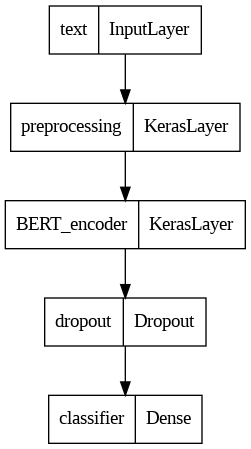

In [11]:
tf.keras.utils.plot_model(classifier_model)

In [11]:
#loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = tf.metrics.CategoricalAccuracy()

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
#batch_size = 32
#seed = 42

In [12]:
#from official.nlp import optimization
#epochs = 5
#steps_per_epoch = tf.data.experimental.cardinality(X_train).numpy() ### here is the problem!
#num_train_steps = steps_per_epoch * epochs
#num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
#optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          #num_train_steps=num_train_steps,
                                          #num_warmup_steps=num_warmup_steps,
                                          #optimizer_type='adamw')
optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr)

In [13]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)


In [11]:
#text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
#encoder_inputs = preprocessor(text_input)
#outputs = encoder(encoder_inputs)

In [12]:
#l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output']) # rate = 0.1
#l = tf.keras.layers.Dense(6, activation='softmax', name="output")(l) # sigmoid

In [13]:
#model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [14]:
#METRICS = [
      #tf.keras.metrics.CategoricalAccuracy(name='accuracy')
      #tf.keras.metrics.BinaryAccuracy(name='accuracy')#,
      #tf.keras.metrics.Precision(name='precision'),
      #tf.keras.metrics.Recall(name='recall')
#]

#model.compile(optimizer='adam',
 #loss='categorical_crossentropy',
 #metrics=METRICS)

In [20]:
classifier_model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/3
120/120 [==============================] - 782s 7s/step - loss: 0.6946 - categorical_accuracy: 0.7195 - val_loss: 1.3663 - val_categorical_accuracy: 0.4948
Epoch 2/3
120/120 [==============================] - 780s 6s/step - loss: 0.5610 - categorical_accuracy: 0.7872 - val_loss: 1.4172 - val_categorical_accuracy: 0.4844
Epoch 3/3
120/120 [==============================] - 779s 6s/step - loss: 0.4511 - categorical_accuracy: 0.8297 - val_loss: 1.6708 - val_categorical_accuracy: 0.4865


In [ ]:
#tf.keras.models.save_model()
# tf.keras.models.load_model()
#tf.keras.saving.save_model(
    #model, "/Users/matteofrison/Desktop/ML project/BERT", overwrite=True, save_format=None
#)


In [21]:
y_final = classifier_model.predict(unlabelled_test_data['sentence'])

38/38 [==============================] - 62s 2s/step


In [22]:
predicted_labels = np.argmax(y_final, axis=1)
label_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}
translated_labels = [label_mapping[idx] for idx in predicted_labels]

In [23]:
sample_submission['difficulty'] = translated_labels

In [24]:
csv_file_path = '/sample_submission_4.csv' # change to _4

# Export the DataFrame to CSV
sample_submission.to_csv(csv_file_path, index=False)

In [25]:
from google.colab import files

# Download the CSV file from Colab to your local machine
files.download("/sample_submission_4.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>